# <tt>synphot</tt>: Predicting photometric magnitudes with an empirical spectrum

## Authors
Tiffany Jansen, Brett Morris, Pey Lian Lim, & Erik Tollerud

## Objectives
<ul>
<li>Query data directly from other websites using `astropy.coordinates.Skycoord`, `astroquery.sdss`, and `tynt`</li>
<li>Construct a source spectrum using `synphot.SourceSpectrum`</li>
<li>Simulate bandpass throughput with `synphot.SpectralElement`</li>
<li>Model effects on the source spectrum such as atmospheric transmission and quantum efficiency with `synphot.SpectralElement`</li>
<li>Combine all of these effects into a simulated observation with `synphot.Observation`</li>
<li>Compute the expected count rate from this observation with `synphot`'s `countrate()` function
</ul>

## Keywords
synphot, synthetic photometry, tynt, astropy, astroquery, astronomy

## Summary
In this tutorial we will:
<ol>
<li><a href="#query_properties">Query the properties of our target star</a> (HAT-P-11 to start)</li>
<li><a href="#phoenix">Download model spectra from PHOENIX</a></li>
<li><a href="#source_spectrum">Construct a source spectrum</a></li>
<li><a href="#bandpass">Create the bandpass of observation</a></li>
<li><a href="#atmosphere">Model attenuation by the atmosphere</a></li>
<li><a href="#qe">Model the effect of the quantum efficiency</a></li>
<li><a href="#observation">Combine all of the effects and "observe"</a></li>
<li><a href="#counts">Compute the count rate and total counts</a></li>
<li><a href="#trappist1">Look at another example, this time with TRAPPIST-1</a></li>
<li><a href="#kepler">Simulate observations with a space-based telescope</a></li>
<li><a href="#compare">Compare simulated counts to observed counts</a></li>
</ol>

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Select an observed spectrum with a strong Halpha emission line from SDSS

In this example we choose the galaxy <a href="https://skyserver.sdss.org/dr12/en/tools/explore/Summary.aspx?id=1237662301903192106" target="_blank">IRAS F15163+4255 NW</a>.

Set the coordinates for the object:

In [44]:
import astropy.units as u
from astropy.coordinates import SkyCoord

ra = 229.525575754 * u.degree
dec = 42.745853761 * u.degree
coords = SkyCoord(ra, dec)

Retrieve the observed spectrum from SDSS:

In [45]:
from astroquery.sdss import SDSS
from synphot import units

spectrum_fits = SDSS.get_spectra(coordinates=coords)
data = spectrum_fits[0][1].data

wavelengths = 10 ** data['loglam'] * u.angstrom
flux = data['flux'] * 1e-17 * units.FLAM  # units are given in 10^-17 ergs/s/cm^2/AA

//anaconda/lib/python3.5/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


### Construct a `synphot` source spectrum object from the empirical spectrum:

Make the source spectrum object with <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">SourceSpectrum</a>:

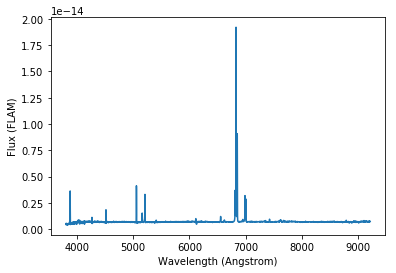

In [46]:
from synphot.spectrum import SourceSpectrum
from synphot.models import Empirical1D

spectrum = SourceSpectrum(Empirical1D,
                          points=wavelengths, lookup_table=flux)

spectrum.plot(flux_unit='FLAM')

### Model the bandpasses

We query the SDSS filter transmission functions from <a href="http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=voservice">SVO</a> using the <a href="https://tynt.readthedocs.io/en/latest/index.html">tynt</a> package. These transmission functions include the effect of the CCD's quantum efficiency on the spectrum.

To construct a bandpass from an array with `synphot`, use <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum">SpectralElement</a> with the Empirical1D model:

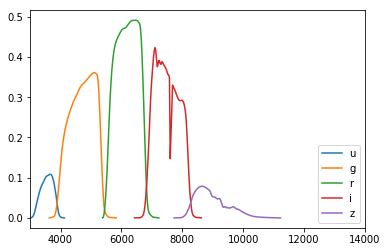

In [47]:
import tynt
from synphot.spectrum import SpectralElement

sdss_bands = ['u', 'g', 'r', 'i', 'z']

f = tynt.FilterGenerator()

bandpasses = {}
for band in sdss_bands:
    filt = f.download_true_transmittance('SLOAN/SDSS.' + band)
    bp = SpectralElement(Empirical1D,
                         points=filt.wavelength,
                         lookup_table=filt.transmittance)
    bandpasses[band] = bp
    
    plt.plot(bp.waveset, bp(bp.waveset), label=band)
plt.legend(loc='lower right')
plt.xlim(3000, 14000)
plt.show()

You can also construct a bandpass from a file using <tt>synphot</tt>'s <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum.SpectralElement.from_file">SpectralElement.from_file()</a>

Once we have all of the effects on the source spectrum set, we can combine them together by simply multiplying the SpectralElement objects:

### Model the observation

In [54]:
from synphot.observation import Observation

mags = {}
for band in sdss_bands:
    observation = Observation(spectrum, bandpasses[band], force='extrap')
    mags[band] = observation.effstim('ABmag').value

# SDSS mags aren't exactly equal to AB mags. Apply corrections
mags['u'] += 0.04
mags['z'] -= 0.02

In [55]:
for band in sdss_bands:
    print(band + ' mag =', np.round(mags[band], 5))

u mag = 18.05164
g mag = 17.10053
r mag = 16.47924
i mag = 16.0022
z mag = 15.70309


### Compare the u,g,r,i,z empirical magnitudes to what we predict with synphot

Get the magnitudes measured by the SDSS fibers

In [56]:
fiber_mags = ['fiberMag_' + band for band in sdss_bands]
mag_table = SDSS.query_crossid(coordinates = coords, photoobj_fields=fiber_mags)

//anaconda/lib/python3.5/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


In [57]:
mag_table

obj_id,objID,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,obj_id1,type
bytes5,int64,float64,float64,float64,float64,float64,int64,bytes6
obj_0,1237662301903192106,18.43611,17.3877,16.79793,16.32855,15.95897,1237662301903192106,GALAXY


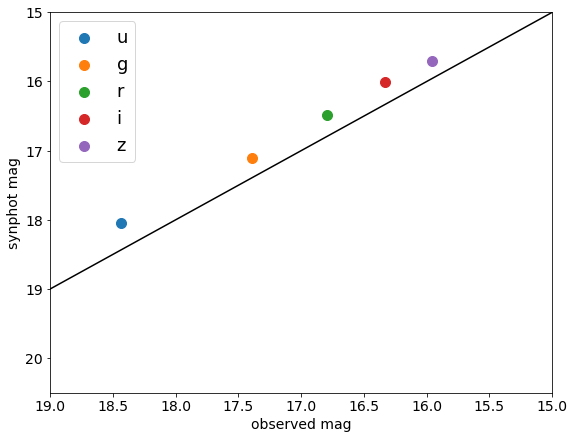

In [58]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(9, 7))

for band in sdss_bands:
    plt.scatter(mag_table['fiberMag_' + band], mags[band],
                s=100, label=band)

# one-to-one line
magrange = np.linspace(15, 19, 10)
plt.plot(magrange, magrange, color='black')

plt.ylabel('synphot mag', size='14')
plt.xlabel('observed mag', size='14')

plt.xlim(19, 15)
plt.ylim(20.5, 15)

plt.legend(prop={'size': 18})